In [1]:
import os 
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig, pipeline, logging
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [3]:
dataset="bentrevett/multi30k"
model_id="microsoft/phi-2"
output_model="phi2-multi30k-v1"

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
# Instruct chat template chat template
#inputs = tokenizer("Instruct: translate the guy with the orange hat is staring at something to german\nOutput:", return_tensors="pt", return_attention_mask=False)

inputs = tokenizer("Instruct: translate English to German.\nInput: the guy with the orange hat is staring at something.\nOutput:", return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=200)
text = tokenizer.batch_decode(outputs)[0]
print(text)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: translate English to German.
Input: the guy with the orange hat is staring at something.
Output: Der Mann mit der orange Haut ist ganz zurückgehend.
<|endoftext|>


In [4]:
def formatted_prompt(question)-> str:
    return f"Instruct: Translate English to German.\nInput: {question}\nOutput:"

In [5]:
def formatted_train(question, response):
    instruction_key = "Instruct: Translate English to German."
    return f"{instruction_key}\nInput: {question}\nOutput: {response}"

def prepare_train_data_multi_30k(data_id):
    data = load_dataset(data_id, split="train")
    data_df = data.to_pandas()
    data_df["text"] = data_df[["de", "en"]].apply(lambda x: "Instruct: Translate English to German\nInput: " + x['en'] + "\nOutput: " + x['de'], axis=1)
    data = Dataset.from_pandas(data_df)
    return data

In [6]:
data = prepare_train_data_multi_30k(dataset)
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [7]:
def get_model_and_tokenizer(mode_id):
    # use tokenizer from llama2
    tokenizer = AutoTokenizer.from_pretrained(model_id,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
    tokenizer.pad_token = tokenizer.eos_token
    # uses bits and bytes package
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True
    )
    # loads the model
    model = AutoModelForCausalLM.from_pretrained(
        mode_id, quantization_config=bnb_config, device_map="auto"
    )
    model.config.use_cache=False
    model.config.pretraining_tp=1
    # returns a model and tokenizer
    return model, tokenizer




In [8]:
model, tokenizer = get_model_and_tokenizer(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262364160
all model parameters: 1521392640
percentage of trainable model parameters: 17.24%


In [10]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
# setup Lora configurations
peft_config = LoraConfig( # we can have different configurations, will test later
        r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "k_proj", "v_proj", "dense"],
    )
# config = LoraConfig(
#     r=32, #Rank
#     lora_alpha=32,
#     target_modules=[
#         'q_proj',
#         'k_proj',
#         'v_proj',
#         'dense'
#     ],
#     bias="none",
#     lora_dropout=0.05,  # Conventional
#     task_type="CAUSAL_LM",
# )

# # 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
# model.gradient_checkpointing_enable()

# # 2 - Using the prepare_model_for_kbit_training method from PEFT
# original_model = prepare_model_for_kbit_training(model)

# peft_model = get_peft_model(original_model, config)

In [11]:
data

Dataset({
    features: ['en', 'de', 'text'],
    num_rows: 29000
})

In [10]:
output_dir = 'phi2-multi30k-en-ger-v1'
import transformers

training_arguments = TrainingArguments(
        warmup_steps=1,
        output_dir=output_model,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        optim="paged_adamw_8bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=10,
        num_train_epochs=1,
        fp16=True,
        # push_to_hub=True
)

trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=1024,
       # data_collator=transformers.DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False), 
    )

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

In [11]:
torch.cuda.empty_cache() 

In [12]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 7ammadi21 (7ammadi). Use `wandb login --relogin` to force relogin


  0%|          | 0/7250 [00:00<?, ?it/s]

{'loss': 3.0224, 'grad_norm': 1.1438884735107422, 'learning_rate': 0.00019999939897423602, 'epoch': 0.0}
{'loss': 2.472, 'grad_norm': 1.9803158044815063, 'learning_rate': 0.00019999695731945193, 'epoch': 0.0}
{'loss': 2.0821, 'grad_norm': 2.419009208679199, 'learning_rate': 0.00019999263751736143, 'epoch': 0.0}
{'loss': 1.9481, 'grad_norm': 2.2339742183685303, 'learning_rate': 0.000199987143945862, 'epoch': 0.01}
{'loss': 1.8691, 'grad_norm': 2.0010619163513184, 'learning_rate': 0.00019997925591656946, 'epoch': 0.01}
{'loss': 1.8564, 'grad_norm': 1.61525297164917, 'learning_rate': 0.00019996949007243907, 'epoch': 0.01}
{'loss': 1.722, 'grad_norm': 1.5216885805130005, 'learning_rate': 0.00019995784659689338, 'epoch': 0.01}
{'loss': 1.6487, 'grad_norm': 1.731565237045288, 'learning_rate': 0.0001999443257086206, 'epoch': 0.01}
{'loss': 1.7432, 'grad_norm': 1.5749250650405884, 'learning_rate': 0.0001999289276615707, 'epoch': 0.01}
{'loss': 1.6853, 'grad_norm': 1.6870571374893188, 'learning

TrainOutput(global_step=7250, training_loss=1.302021213399953, metrics={'train_runtime': 4542.1319, 'train_samples_per_second': 6.385, 'train_steps_per_second': 1.596, 'train_loss': 1.302021213399953, 'epoch': 1.0})

In [12]:
from peft import AutoPeftModelForCausalLM, PeftModel
from transformers import AutoModelForCausalLM
import torch
import os

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, load_in_8bit=False,
                                             device_map="auto",
                                             trust_remote_code=True)

#model_path = "/content/tinyllama-colorist-v1/checkpoint-250"
model_path = "phi2-multi30k-v1/checkpoint-7250"

peft_model = PeftModel.from_pretrained(model, model_path, from_transformers=True, device_map="auto")

model = peft_model.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,),

In [13]:
from transformers import GenerationConfig
from time import perf_counter

def generate_response(user_input):

  prompt = formatted_prompt(user_input)

  inputs = tokenizer([prompt], return_tensors="pt")
  generation_config = GenerationConfig(penalty_alpha=0.6,do_sample = True,
      top_k=5,temperature=0.5,repetition_penalty=1.2,
      max_new_tokens=20,pad_token_id=tokenizer.eos_token_id
  )
  start_time = perf_counter()

  inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

  outputs = model.generate(**inputs, generation_config=generation_config)
  output=tokenizer.decode(outputs[0], skip_special_tokens=True)
  #print(output)
  output_time = perf_counter() - start_time
  #print(f"Time taken for inference: {round(output_time,2)} seconds")
  return output

In [14]:
data_test = load_dataset(dataset, split="test")

In [15]:
import re
mydf = pd.DataFrame(columns=['de','en','predicted_de'])
for i in tqdm(range(0,len(data_test))):
    out=generate_response(user_input=data_test[i]['en'])
    out=out.split('Output: ')[1]
    #processed_out=re.sub("[^A-Za-z0-9., ]","",out)
    mydf=pd.concat([mydf,pd.DataFrame({'de':data_test[i]['de'],'en':data_test[i]['en'],'predicted_de':out},index=[0])],ignore_index=True)
    

100%|██████████| 1000/1000 [09:11<00:00,  1.81it/s]


In [16]:
mydf.to_csv('phi2-multi30k-v1-EN-GER.csv',index=False)

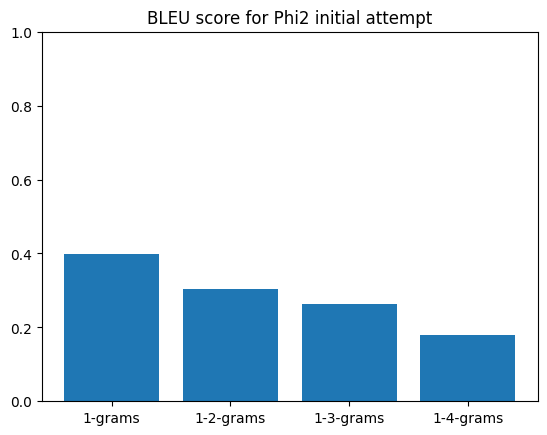

In [17]:
from nltk.translate.bleu_score import corpus_bleu,  SmoothingFunction
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
def bleu_score(csv_file):
  df_input=pd.read_csv(csv_file)
  actual, predicted=[],[]
  count=0
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["de"].split()])
    predicted.append(r["predicted_de"].split())
  #print(actual)
  #print("===")
  #print(predicted)

  bleu_dic={}
  bleu_dic['1-grams']=corpus_bleu(actual, predicted, weights=(1.0,0,0,0))
  bleu_dic['1-2-grams']=corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0))
  bleu_dic['1-3-grams']=corpus_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
  bleu_dic['1-4-grams']=corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
  return bleu_dic

tinyllama_bleu=bleu_score('phi2-multi30k-v1-EN-GER.csv')

plt.bar(x=tinyllama_bleu.keys(), height=tinyllama_bleu.values())
plt.title("BLEU score for Phi2 initial attempt")
plt.ylim((0,1))
plt.show()

In [18]:
tinyllama_bleu

{'1-grams': 0.3996769098121488,
 '1-2-grams': 0.3042815081937937,
 '1-3-grams': 0.26265797579815814,
 '1-4-grams': 0.17803955265143895}

In [19]:
from nltk.translate.bleu_score import sentence_bleu

def bleu_sent_score(csv_file):
  df_input=pd.read_csv(csv_file)
  actual, predicted=[],[]
  count=0
  scores = []
  for _, r in df_input.iterrows():
    #print(r["input_de"])
    #print(r["output_en"])
    #print(r["gt_en"])
    actual.append([r["de"].split()])
    predicted.append(r["predicted_de"].split())

    score = sentence_bleu([r["de"].split()], r["predicted_de"].split())
    scores.append(score)



  return scores


tinyllama_bleu_sent=bleu_sent_score('phi2-multi30k-v1-EN-GER.csv')
import numpy as np
np.array(tinyllama_bleu_sent).mean()
    

0.11717396607183062

In [20]:
import nltk
import numpy as np
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
df_input = pd.read_csv('phi2-multi30k-v1-EN-GER.csv')
df_input = df_input.dropna()
actual, predicted = df_input['de'], df_input['predicted_de']
scores=[]
for reference, hypothesis in zip(actual, predicted):
    tokenized_reference = word_tokenize(reference)
    tokenized_hypothesis = word_tokenize(hypothesis)
    scores.append(meteor_score([tokenized_reference], tokenized_hypothesis))

np.array(scores).mean()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/hamad.alhammadi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0.41985870842725537

In [21]:
from evaluate import load
comet_metric = load("comet")
predicted = df_input['predicted_de'].tolist()
actual = df_input['de'].tolist()
source = df_input['en'].tolist()
results = comet_metric.compute(predictions=predicted, references=actual, sources=source)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
results

{'mean_score': 0.5962702080011367,
 'scores': [0.4412861764431,
  0.46389710903167725,
  0.3634698688983917,
  0.6874225735664368,
  0.4601365923881531,
  0.4709911048412323,
  0.6286498308181763,
  0.37637612223625183,
  0.8111923336982727,
  0.686951220035553,
  0.4998358190059662,
  0.33985549211502075,
  0.668775737285614,
  0.4754548966884613,
  0.4181016981601715,
  0.3706153929233551,
  0.6015293598175049,
  0.5356162190437317,
  0.8355199694633484,
  0.36897486448287964,
  0.8430176377296448,
  0.7646458745002747,
  0.7217810153961182,
  0.7342789769172668,
  0.29266786575317383,
  0.7345629334449768,
  0.6766157746315002,
  0.5289424061775208,
  0.5356197953224182,
  0.3407313823699951,
  0.8292561173439026,
  0.6242266297340393,
  0.8167948126792908,
  0.5593011975288391,
  0.9201875329017639,
  0.24081498384475708,
  0.44100531935691833,
  0.3576207160949707,
  0.7989457249641418,
  0.6665067076683044,
  0.28996628522872925,
  0.7446200847625732,
  0.5943838953971863,
  0.58